In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

N, D1, D2 = train_data.data.shape
D = D1 * D2
Nc = 10

In [3]:
class Model(nn.Module):
    def __init__(self, D, Nc):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(D, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,Nc),       
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.net(x)
        return logits

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Model(D, Nc).to(device)

loss_f = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
epochs = 5

perf = {"accuracy":[], "loss":[]}
perf_test = {"accuracy":[], "loss":[]}
for epoch in range(epochs):
    n_batch = len(train_loader)
    sz = len(train_loader.dataset)
    loss_epoch = 0
    correct_epoch = 0
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        correct_epoch += (pred.argmax(dim=1)==y).type(torch.float).sum().item()
        loss = loss_f(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_epoch += loss.item()
    correct_epoch /= sz
    loss_epoch /= n_batch
    perf["accuracy"].append(correct_epoch)
    perf["loss"].append(loss_epoch)
    print(f"{epoch}-Train: loss = {loss_epoch:>.2e}, acc = {correct_epoch:>.2f}")
    
    with torch.no_grad():
        n_batch = len(test_loader)
        sz = len(test_loader.dataset)
        loss_epoch = 0
        correct_epoch = 0
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            correct_epoch += (pred.argmax(1)==y).type(torch.float).sum().item()
            loss_epoch += loss.item()
        correct_epoch /= sz
        loss_epoch /= n_batch
        perf_test["accuracy"].append(correct_epoch)
        perf_test["loss"].append(loss_epoch)
        print(f"{epoch}-Test: loss = {loss_epoch:>.2e}, acc = {correct_epoch:>.2f}")
        
             

0: loss = 2.27e+00, acc = 0.15
1: loss = 2.16e+00, acc = 0.30
2: loss = 1.94e+00, acc = 0.56
3: loss = 1.62e+00, acc = 0.61
4: loss = 1.35e+00, acc = 0.61


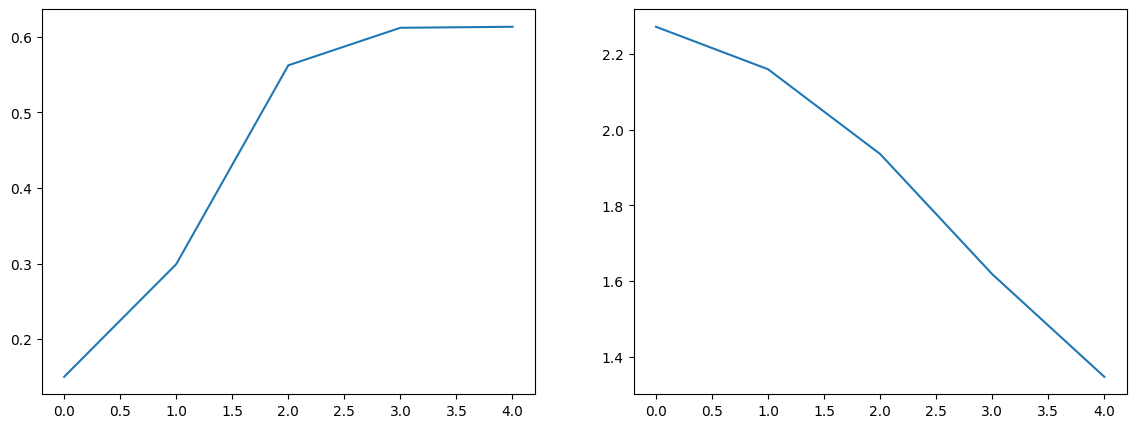

In [24]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(perf["accuracy"])
plt.subplot(1,2,2)
plt.plot(perf["loss"])